# **Topic Modeling and Sentiment Analysis over Customer Support data on Twiter**


**Group Members:**


    





1. 202418013 - Darshita Dwivedi
2. 202418025 - Kelvi Bhesdadiya
3. 202418057 - Eric Thomas
4. 202418058 - Ujjwal Bhansali   





# Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import nltk
from tqdm import tqdm
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.decomposition import NMF

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ericp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ericp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ericp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ericp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**The dataset used in this project is sourced from Kaggle: https://www.kaggle.com/datasets/thoughtvector/customer-support-on-twitter**


In [2]:
df = pd.read_csv('twcs.csv') 

In [3]:
df

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


C:\Users\ericp\AppData\Local\Temp\ipykernel_9048\3926328343.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=author_counts.index, y=author_counts.values, palette='viridis')


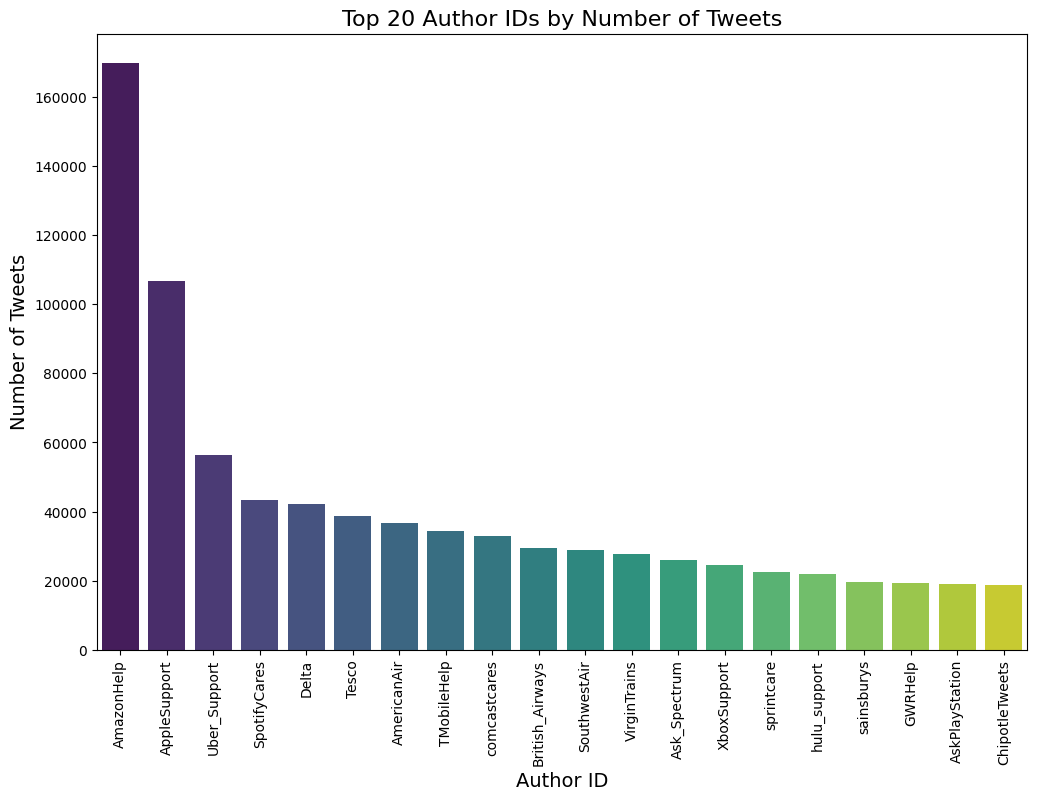

In [4]:
author_counts = df['author_id'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=author_counts.index, y=author_counts.values, palette='viridis')

plt.xlabel('Author ID', fontsize=14)
plt.ylabel('Number of Tweets', fontsize=14)
plt.title('Top 20 Author IDs by Number of Tweets', fontsize=16)

plt.xticks(rotation=90)

plt.show()

# Preprocessing

By converting all text data to lowercase, we standardize the text, making it easier to work with

In [5]:
df['cleaned_text'] = df['text'].str.lower()

By removing URLs from the text data using a regular expression, we ensure that irrelevant links do not influence text analysis, making the dataset cleaner and more suitable for tasks like sentiment analysis, keyword extraction, or topic modeling.








In [6]:
url_pattern = re.compile(r'https?://\S+|www\.\S+')
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: url_pattern.sub(r'', x))

Using `BeautifulSoup`, HTML tags are stripped from the text, simplifying it for analysis.

In [7]:
tqdm.pandas()
df['cleaned_text'] = df['cleaned_text'].progress_apply(lambda x: BeautifulSoup(x, "lxml").text)

  0%|          | 0/2811774 [00:00<?, ?it/s]C:\Users\ericp\AppData\Local\Temp\ipykernel_9048\2994410141.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['cleaned_text'] = df['cleaned_text'].progress_apply(lambda x: BeautifulSoup(x, "lxml").text)
100%|██████████| 2811774/2811774 [05:42<00:00, 8198.78it/s] 


Using a regex pattern, emojis are removed from the text, ensuring a neutral and cleaner dataset for analysis.

In [8]:
emoji_pattern = re.compile("[" 
                            u"\U0001F600-\U0001F64F"  
                            u"\U0001F300-\U0001F5FF"  
                            u"\U0001F680-\U0001F6FF"  
                            u"\U0001F1E0-\U0001F1FF"  
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            "]+", flags=re.UNICODE)
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: emoji_pattern.sub(r'', x))

Stopwords are filtered out to retain only meaningful words, improving text analysis efficiency.

In [9]:
tqdm.pandas()
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].progress_apply(
    lambda x: " ".join([word for word in word_tokenize(x) if word not in stop_words])
)

100%|██████████| 2811774/2811774 [05:02<00:00, 9284.09it/s] 


Words are lemmatized to their base forms using `WordNetLemmatizer`, reducing inflected forms and standardizing the text for better analysis.

In [10]:
lemmatizer = WordNetLemmatizer()
tqdm.pandas()

df['cleaned_text'] = df['cleaned_text'].progress_apply(
    lambda x: " ".join([lemmatizer.lemmatize(word, pos='v') if wordnet.synsets(word) else word for word in word_tokenize(x)])
)

100%|██████████| 2811774/2811774 [13:07<00:00, 3568.62it/s]


In [11]:
df[['text', 'cleaned_text']]

,text,cleaned_text
0,@115712 I understand. I would like to assist y...,@ 115712 understand . would like assist . woul...
1,@sprintcare and how do you propose we do that,@ sprintcare propose
2,@sprintcare I have sent several private messag...,@ sprintcare send several private message one ...
3,@115712 Please send us a Private Message so th...,@ 115712 please send us private message assist...
4,@sprintcare I did.,@ sprintcare .
...,...,...
2811769,"@823869 Hey, we'd be happy to look into this f...","@ 823869 hey , 'd happy look . please send us ..."
2811770,@115714 wtf!? I’ve been having really shitty s...,@ 115714 wtf ! ? ’ really shitty service day !...
2811771,@143549 @sprintcare You have to go to https://...,@ 143549 @ sprintcare go ask add hulu service ...
2811772,"@823870 Sounds delicious, Sarah! 😋 https://t.c...","@ 823870 sound delicious , sarah !"


The function assigns a company name based on tweet interactions and mentions, linking tweets to the corresponding company for contextual analysis.

In [12]:
tqdm.pandas()

company_author_ids = {
    'AppleSupport': 'Apple',
    'AmericanAir': 'American Airlines',
    'Ask_Spectrum': 'Spectrum'
}

def assign_company_name(row, company_author_ids):
    if row['inbound']:
        if not pd.isna(row['in_response_to_tweet_id']):
            response_tweet = df[df['tweet_id'] == row['in_response_to_tweet_id']]
            if not response_tweet.empty:
                response_author = response_tweet.iloc[0]['author_id']
                if response_author in company_author_ids:
                    return company_author_ids[response_author]
        for company in company_author_ids.keys():
            if f"@{company.lower()}" in row['text'].lower():
                return company_author_ids[company]
    return None

df['company_name'] = df.progress_apply(assign_company_name, axis=1, company_author_ids=company_author_ids)

100%|██████████| 2811774/2811774 [54:48<00:00, 855.15it/s]  


Filter the DataFrame to include only customer tweets where `inbound` is `True`

In [37]:
df_customer_tweets = df[df['inbound'] == True]

Drop unnecessary columns from `df_customer_tweets`, keeping only relevant data for further analysis.

In [38]:
warnings.filterwarnings("ignore")
df_customer_tweets.drop(columns=['tweet_id','author_id','inbound','created_at','in_response_to_tweet_id','text'	,'response_tweet_id'], inplace=True)

Group `df_customer_tweets` by `company_name` for company-specific analysis

In [39]:
company_groups = df_customer_tweets.groupby('company_name')

Extract tweets specific to `Apple`, `American Airlines`, and `Spectrum` from the grouped data for targeted analysis

In [40]:
apple_tweets = company_groups.get_group('Apple')
americanair_tweets = company_groups.get_group('American Airlines')
spectrum_tweets = company_groups.get_group('Spectrum')

In [41]:
company_tweet_dataframes = [
    apple_tweets,
    americanair_tweets,
    spectrum_tweets
]

# Sentiment Analysis:

Clean the text by removing non-alphabetic characters and filtering out author names from the tweets, ensuring the text is ready for further analysis

In [42]:
warnings.filterwarnings("ignore")

for df in company_tweet_dataframes:
    if 'company_name' in df.columns:
        df.drop(columns=['company_name'], inplace=True)
    
    author_ids_to_remove = list(company_author_ids.keys())
    
    tqdm.pandas(desc="Cleaning Text")
    df['cleaned_text'] = df['cleaned_text'].progress_apply(lambda text: " ".join(
        word for word in text.split()
        if re.sub(r'[^a-zA-Z\s]', '', word) and 
           re.sub(r'[^a-zA-Z\s]', '', word).lower() not in [str(author).lower() for author in author_ids_to_remove]
    ))

Cleaning Text: 100%|██████████| 23659/23659 [00:00<00:00, 40591.34it/s]


Performs sentiment analysis on tweets for each company, labels them as positive, neutral, or negative based on the compound score, and visualizes sentiment distribution using a count plot for each company. The results are stored in `sentiment_results` for further analysis.

Analyzing Sentiments:   0%|          | 0/3 [00:00<?, ?it/s]

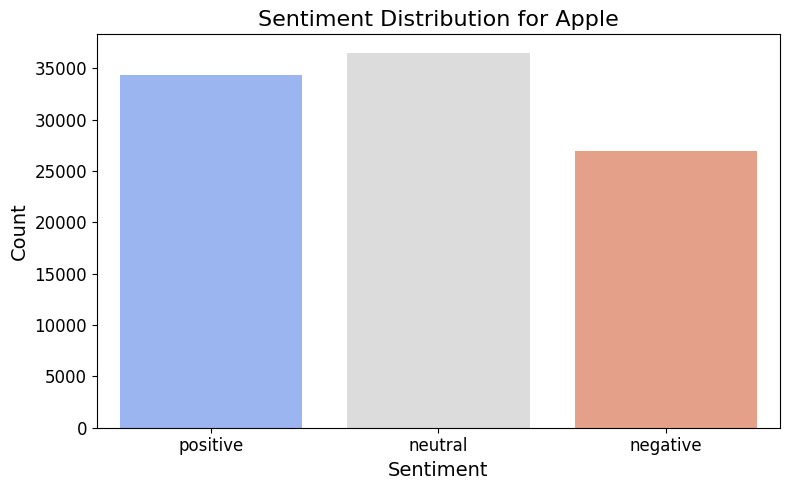

Analyzing Sentiments:  33%|███▎      | 1/3 [00:08<00:17,  8.99s/it]

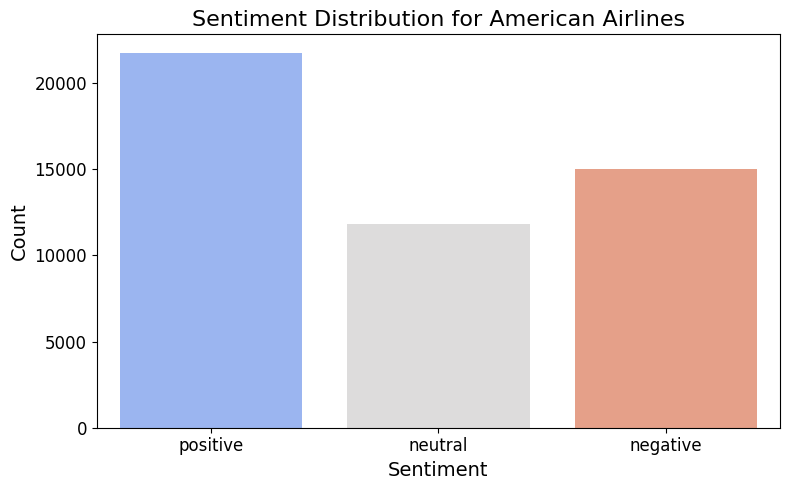

Analyzing Sentiments:  67%|██████▋   | 2/3 [00:14<00:06,  6.87s/it]

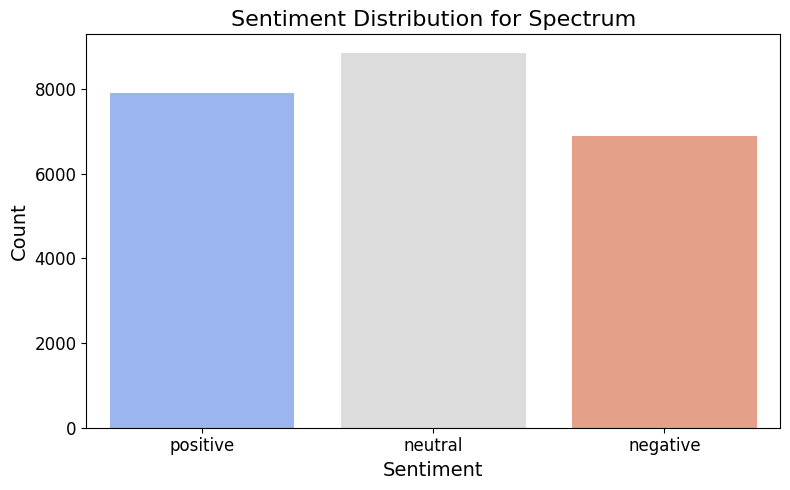

Analyzing Sentiments: 100%|██████████| 3/3 [00:17<00:00,  5.73s/it]


In [43]:
warnings.filterwarnings("ignore")

sia = SentimentIntensityAnalyzer()

sentiment_results = {}

company_names = [
    'Apple','American Airlines','Spectrum'
]

for i, (df, company_name) in tqdm(enumerate(zip(company_tweet_dataframes, company_names)), 
                                  total=len(company_tweet_dataframes), 
                                  desc="Analyzing Sentiments"):
    df['sentiment_scores'] = df['cleaned_text'].apply(sia.polarity_scores)
    df['neg'] = df['sentiment_scores'].apply(lambda x: x['neg'])
    df['neu'] = df['sentiment_scores'].apply(lambda x: x['neu'])
    df['pos'] = df['sentiment_scores'].apply(lambda x: x['pos'])
    df['compound'] = df['sentiment_scores'].apply(lambda x: x['compound'])

    df['sentiment_label'] = df['compound'].apply(lambda x: 'positive' if x > 0.05 
                                                 else ('negative' if x < -0.05 
                                                       else 'neutral'))
    sentiment_results[company_name] = df[['cleaned_text', 'neg', 'neu', 'pos', 'compound', 'sentiment_label']]
    company_tweet_dataframes[i] = df

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='sentiment_label', order=['positive', 'neutral', 'negative'], palette='coolwarm')
    plt.title(f"Sentiment Distribution for {company_name}", fontsize=16)
    plt.xlabel("Sentiment", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# **Topic Modeling**

### 1) LDA (Latent Dirichlet Allocation)

Tokenize the cleaned_text for Apple tweets, creating a list of words and preparing a corpus for topic modeling using the Dictionary and doc2bow methods

In [44]:
texts = [text.split() for text in apple_tweets['cleaned_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

**Calculate coherence scores** for topic models with 2 to 5 topics using `LdaModel` and selects the optimal number of topics based on the highest coherence score.

In [45]:
coherence_scores = []

for num_topics in tqdm(range(2, 6), desc="Calculating Coherence Scores"):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

optimal_topics = coherence_scores.index(max(coherence_scores)) + 2
print("Optimal number of topics:", optimal_topics)

Calculating Coherence Scores: 100%|██████████| 4/4 [02:17<00:00, 34.41s/it]

Optimal number of topics: 3


The optimal number of topics for the LDA model is 3, based on the highest coherence score.

**Plots a graph** showing the relationship between the number of topics and coherence scores to visualize the optimal number of topics

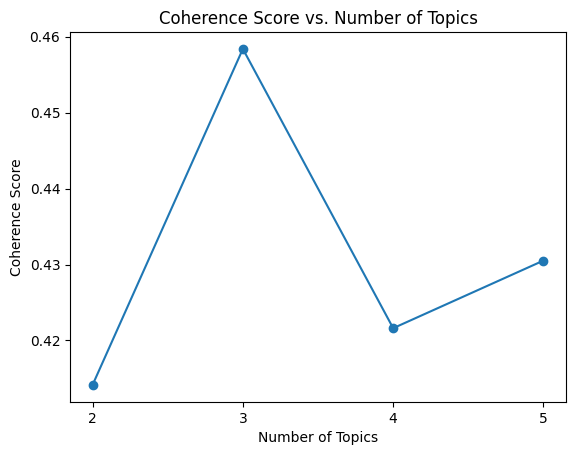

In [46]:
plt.plot(range(2, 6), coherence_scores, marker='o')
plt.title("Coherence Score vs. Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(range(2, 6))
plt.show()

**Trains an LDA model with 3 topics**, and displays the top 10 words for each topic to interpret the learned topics

In [51]:
lda_model_3 = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42)

for i, topic in lda_model_3.show_topics(num_topics=3, formatted=True,num_words=10):
    print(f"Topic {i+1}: {topic}")

Topic 1: 0.026*"thank" + 0.022*"apple" + 0.018*"n't" + 0.017*"help" + 0.015*"get" + 0.012*"try" + 0.010*"send" + 0.009*"say" + 0.008*"please" + 0.008*"need"
Topic 2: 0.036*"phone" + 0.034*"update" + 0.019*"fix" + 0.019*"time" + 0.018*"go" + 0.017*"battery" + 0.016*"get" + 0.013*"app" + 0.013*"ios" + 0.011*"happen"
Topic 3: 0.049*"iphone" + 0.030*"work" + 0.027*"ios" + 0.017*"update" + 0.016*"phone" + 0.014*"screen" + 0.011*"apple" + 0.011*"new" + 0.011*"x" + 0.010*"use"


Assigning the most probable topic name to each tweet based on the LDA model's topic distribution

In [53]:
topic_names = {
    0: "customer service",
    1: "Battery and Update Problems",
    2: "iPhone Functionality and Technical Issues"
}

apple_tweets['topic_id'] = [
    max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus
]

apple_tweets['topic_name'] = apple_tweets['topic_id'].map(topic_names)

apple_tweets[['cleaned_text', 'topic_name']]

,cleaned_text,topic_name
397,newest update make sure download yesterday,Battery and Update Problems
399,,customer service
400,change show correctly social media platforms,iPhone Functionality and Technical Issues
402,try reset settings restart phone,iPhone Functionality and Technical Issues
404,look like,NaN
...,...,...
2811311,update slack everything seem work well thank '...,iPhone Functionality and Technical Issues
2811420,hey able duplicate file page search really ann...,NaN
2811422,yo weird glitch w/ capital attempt make tweet ...,NaN
2811484,fuck phone keep hang call show call failure,iPhone Functionality and Technical Issues


**Aggregating Topics & Sentiment**

Analyzing the sentiment distribution across different topics by calculating the normalized value counts of sentiment labels for each topic

In [54]:
sentiment_topic_analysis = apple_tweets.groupby('topic_name')['sentiment_label'].value_counts(normalize=True).unstack()
print(sentiment_topic_analysis)

sentiment_label                            negative   neutral  positive
topic_name                                                             
Battery and Update Problems                0.407715  0.305517  0.286768
customer service                           0.105047  0.476178  0.418775
iPhone Functionality and Technical Issues  0.241993  0.402863  0.355144


**Battery and Update Problems** has a higher percentage of negative sentiment

**Customer service** has a balanced distribution with a slight lean towards positive sentiment

**iPhone Functionality and Technical Issues** shows a more neutral sentiment distribution with a positive tilt



### 2) NMF (Non-Negative Matrix Factorization)

TF-IDF vectorization is applied to the American Air cleaned text for feature extraction, and a bag-of-words corpus is created from the text data

In [55]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(americanair_tweets['cleaned_text'])

texts = [text.split() for text in americanair_tweets['cleaned_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

NMF models are fitted for different topic counts, and the coherence scores are calculated to evaluate topic quality

Fitting NMF models: 100%|██████████| 14/14 [03:14<00:00, 13.88s/topic]


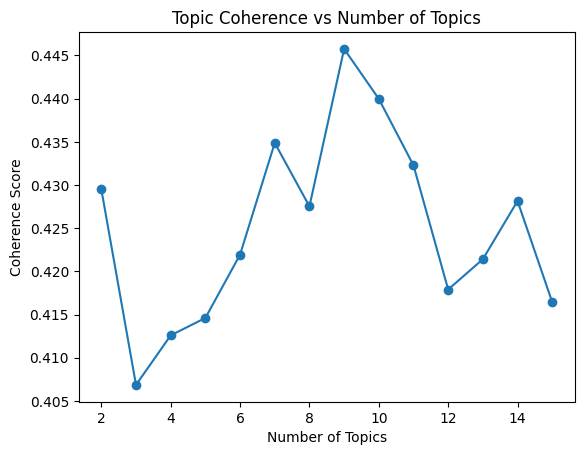

In [56]:
num_topics_range = range(2, 16)
coherence_scores = []

for n_topics in tqdm(num_topics_range, desc="Fitting NMF models", unit="topic"):
    nmf = NMF(n_components=n_topics, random_state=1)
    nmf.fit(X)

    topics = [[dictionary[word_idx] for word_idx in topic.argsort()[:-11:-1]] for topic in nmf.components_]

    coherence_model = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='c_v', texts=texts)
    coherence_scores.append(coherence_model.get_coherence())

plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence vs Number of Topics')
plt.show()

In [57]:
optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal number of topics: {optimal_num_topics}")

Optimal number of topics: 9


The optimal number of topics, based on the highest coherence score, is determined to be 9.

The NMF model has been trained with the optimal number of topics, and the top words for each topic have been printed based on the highest feature importance

In [58]:
nmf = NMF(n_components=optimal_num_topics, random_state=1)
nmf.fit(X)
topic_probs = nmf.transform(vectorizer.transform([text for text in americanair_tweets['cleaned_text']]))

feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(nmf.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: flight, cancel, miss, attendant, book, crew, great, connect, make, home
Topic 2: thank, great, make, appreciate, response, home, reply, ok, help, upgrade
Topic 3: service, customer, great, worst, help, experience, aa, terrible, horrible, airline
Topic 4: bag, check, gate, make, carry, wait, tell, say, agent, force
Topic 5: fly, american, aa, airline, airlines, experience, worst, today, southwestair, like
Topic 6: delay, plane, hours, hour, wait, gate, sit, miss, minutes, board
Topic 7: seat, pay, upgrade, change, ticket, class, book, extra, plane, window
Topic 8: send, dm, help, need, message, info, email, response, number, guy
Topic 9: time, make, change, departure, board, work, travel, like, waste, say


The topic assignments are made based on the highest topic probabilities, with a threshold to label uncertain topics as "Uncertain". The topic names are then mapped accordingly.

In [59]:
topic_names = {
    0: "Flight Cancellations",
    1: "Customer Appreciation",
    2: "Poor Service",
    3: "Baggage Issues",
    4: "Airline Comparison",
    5: "Flight Delays",
    6: "Seat Upgrades",
    7: "Customer Support",
    8: "Travel Delays"
}

threshold = 0.001
topic_ids = np.argmax(topic_probs, axis=1)
uncertain_topic = (topic_probs.max(axis=1) < threshold)

americanair_tweets['topic_id'] = np.where(uncertain_topic, -1, topic_ids)
americanair_tweets['topic_name'] = americanair_tweets['topic_id'].map(topic_names).fillna('Uncertain')

**Aggregating Topics & Sentiment**

analyze the distribution of sentiment labels (negative, neutral, positive) for each topic and normalizes the counts to show the proportion of each sentiment per topic

In [60]:
sentiment_topic_analysis = americanair_tweets.groupby('topic_name')['sentiment_label'].value_counts(normalize=True).unstack()
print(sentiment_topic_analysis)

sentiment_label        negative   neutral  positive
topic_name                                         
Airline Comparison     0.308903  0.241216  0.449881
Baggage Issues         0.328520  0.273767  0.397713
Customer Appreciation  0.068737  0.013493  0.917770
Customer Support       0.148603  0.301439  0.549958
Flight Cancellations   0.317016  0.255155  0.427829
Flight Delays          0.490442  0.227960  0.281598
Poor Service           0.396846  0.108447  0.494707
Seat Upgrades          0.314097  0.240023  0.445880
Travel Delays          0.295466  0.255791  0.448743
Uncertain              0.061592  0.832749  0.105658


**Customer Appreciation** stands out with a high percentage of positive sentiment (91.77%), indicating that users are mostly happy with their experiences.

**Flight Delays** has the highest negative sentiment (49.04%), suggesting significant frustration among users regarding delays.

### 3) LSA (Latent Semantic Analysis)

Transform the cleaned text data from `spectrum_tweets` into a TF-IDF matrix, considering the top 1000 features while removing common English stopwords.

In [61]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(spectrum_tweets['cleaned_text'])

Prepare the text data from `spectrum_tweets` by splitting the cleaned text into words, creating a dictionary, and converting the text into a bag-of-words representation.

In [62]:
texts = [text.split() for text in spectrum_tweets['cleaned_text']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

Fit LSA models for a range of topic numbers (2 to 10), calculate the coherence score for each model, and store the scores for later analysis

In [63]:
num_topics_range = range(2, 11)
coherence_scores = []

for n_topics in tqdm(num_topics_range, desc="Fitting LSA models", unit="topic"):
    lsa_model = TruncatedSVD(n_components=n_topics, random_state=1)
    lsa_topic_matrix = lsa_model.fit_transform(X)
    
    topics = [[dictionary[word_idx] for word_idx in topic.argsort()[:-11:-1]] for topic in lsa_model.components_]

    coherence_model = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='c_v', texts=texts)
    coherence_scores.append(coherence_model.get_coherence())

Fitting LSA models: 100%|██████████| 9/9 [01:54<00:00, 12.74s/topic]


Plot the coherence scores for different numbers of topics to visualize the relationship between the number of topics and the topic coherence

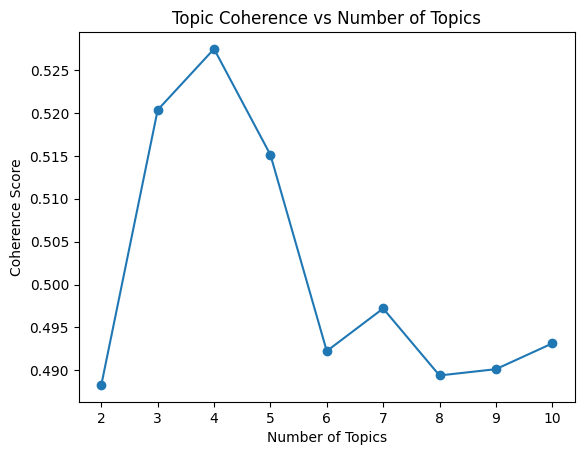

In [64]:
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Topic Coherence vs Number of Topics')
plt.show()

The optimal number of topics is determined based on the highest coherence score, which indicates the best fit for topic modeling.

In [65]:
optimal_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
print(f"Optimal number of topics: {optimal_num_topics}")

Optimal number of topics: 4


Perform LSA topic modeling using the optimal number(4) of topics determined previously, and calculate topic probabilities for the cleaned text data in `spectrum_tweets`

In [66]:
lsa_model = TruncatedSVD(n_components=optimal_num_topics, random_state=1)
lsa_topic_matrix = lsa_model.fit_transform(X)

topic_probs = lsa_model.transform(vectorizer.transform([text for text in spectrum_tweets['cleaned_text']]))

Display the top 10 words for each topic in the LSA model by sorting the feature indices based on the component values

In [68]:
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lsa_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: ask_spectrum, internet, service, thank, outage, work, fix, time, send, area
Topic 2: internet, outage, service, work, area, cable, fix, time, pay, issue
Topic 3: thank, work, service, send, dm, fix, yes, time, ok, spectrum
Topic 4: service, time, spectrum, customer, pay, work, channel, issue, send, like


Assign topics to `spectrum_tweets` by selecting the topic with the highest probability for each tweet and mapping it to a topic name based on predefined labels

In [69]:
topic_names = {
    0: "Service Issues",
    1: "Internet Outages",
    2: "Customer Appreciation",
    3: "Billing Issues"
}

spectrum_tweets['topic_id'] = [
    max(enumerate(topic_probs[i]), key=lambda x: x[1])[0] for i in range(len(topic_probs))
]

spectrum_tweets['topic_name'] = spectrum_tweets['topic_id'].map(topic_names)

**Aggregating Topics & Sentiment**

group the `spectrum_tweets` dataset by `topic_name`, calculate the normalized counts of each `sentiment_label` (positive, neutral, negative) for each topic, and display the result

In [70]:
sentiment_topic_analysis = spectrum_tweets.groupby('topic_name')['sentiment_label'].value_counts(normalize=True).unstack()
print(sentiment_topic_analysis)

sentiment_label        negative   neutral  positive
topic_name                                         
Billing Issues         0.443650  0.224828  0.331522
Customer Appreciation  0.097760  0.012220  0.890020
Internet Outages       0.305653  0.431973  0.262373
Service Issues         0.268235  0.430128  0.301638


**Customer Appreciation:** Predominantly positive (89%), with very few negative (9.8%) or neutral (1.2%) sentiments.

**Billing Issues:** Negative sentiments are the most frequent (44.4%), followed by neutral (22.5%) and positive (33.2%) sentiments.

**Internet Outages:** High proportion of neutral sentiments (43.2%), with negative (30.6%) and positive (26.2%) sentiments relatively balanced.

**Service Issues:** Similar to Internet Outages, with a fairly balanced distribution—neutral (43.0%), negative (26.8%), and positive (30.2%) sentiments.

# Conclusion

**In this assignment for the Unsupervised Learning, topic modeling techniques (LDA, NMF, and LSA) were applied to customer reviews on Twitter to identify underlying themes. Subsequently, sentiment analysis was performed to evaluate customer sentiment toward each topic, offering valuable insights into the customers' perceptions of each company**